# Churn Analysis

_Work done in collaboration with Corey Girard_

A mobile device company is having a major problem with customer retention. Customers switching from one company to another is called *churn*. Our goal in this analysis is to understand the problem, identify behaviors which are strongly correlated with churn and to devise a solution.

In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import json, datetime, csv, time
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [32]:
df = pd.read_csv("./datasets/churn-bigml-20.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


## Data Handling and Feature Engineering

### Reading the data

In [33]:
df = pd.read_csv("./datasets/churn-bigml-20.csv")
df.columns = [c.lower().replace(' ', '_') for c in df.columns.values]
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


### Convert binary strings to boolean ints

In [34]:
df['international_plan'] = df.international_plan.replace({'Yes': 1, 'No': 0})
df['voice_mail_plan'] = df.voice_mail_plan.replace({'Yes': 1, 'No': 0})

### Convert booleans to boolean ints

In [35]:
df['churn'] = df.churn.replace({True: 1, False: 0})

### Handle state dummies

In [36]:
state_dummies = pd.get_dummies(df.state)
state_dummies.columns = ['state_'+c.lower() for c in state_dummies.columns.values]
df.drop('state', axis='columns', inplace=True)
df = pd.concat([df, state_dummies], axis='columns')

### Handle area code dummies

In [37]:
area_dummies = pd.get_dummies(df.area_code)
area_dummies.columns = ['area_code_'+str(c) for c in area_dummies.columns.values]
df.drop('area_code', axis='columns', inplace=True)
df = pd.concat([df, area_dummies], axis='columns')

### Feature Engineering

In [38]:
df['total_minutes'] = df.total_day_minutes + df.total_eve_minutes + df.total_intl_minutes
df['total_calls'] = df.total_day_calls + df.total_eve_calls + df.total_intl_calls
df['total_charge'] = df.total_day_charge + df.total_eve_charge + df.total_intl_charge

df['avg_day_rate_by_minute'] = df.total_day_charge / df.total_day_minutes
df['avg_day_rate_by_call'] = df.total_day_charge / df.total_day_calls

df['avg_eve_rate_by_minute'] = df.total_eve_charge / df.total_eve_minutes
df['avg_eve_rate_by_call'] = df.total_eve_charge / df.total_eve_calls

df['avg_night_rate_by_minute'] = df.total_night_charge / df.total_night_minutes
df['avg_night_rate_by_call'] = df.total_night_charge / df.total_night_calls

df['avg_intl_rate_by_minute'] = df.total_intl_charge / df.total_intl_minutes
df['avg_intl_rate_by_call'] = df.total_intl_charge / df.total_intl_calls
df.fillna(value=0.0, inplace=True) # three people made no international calls, apparently

df['pct_calls_left_voicemail'] = df.number_vmail_messages / df.total_calls

df['ratio_minutes_day_eve'] = df.total_day_minutes / df.total_eve_minutes
df['ratio_minutes_day_night'] = df.total_day_minutes / df.total_night_minutes
df['ratio_minutes_eve_night'] = df.total_eve_minutes / df.total_night_minutes

df['ratio_calls_day_eve'] = df.total_day_calls / df.total_eve_calls
df['ratio_calls_day_night'] = df.total_day_calls / df.total_night_calls
df['ratio_calls_eve_night'] = df.total_eve_calls / df.total_night_calls

### Features and target

In [40]:
X = df[[c for c in df.columns if c != 'churn']]
y = df.churn

X.head()
y[0:5]

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,area_code_408,area_code_415,area_code_510,total_minutes,total_calls,total_charge,avg_day_rate_by_minute,avg_day_rate_by_call,avg_eve_rate_by_minute,avg_eve_rate_by_call,avg_night_rate_by_minute,avg_night_rate_by_call,avg_intl_rate_by_minute,avg_intl_rate_by_call,pct_calls_left_voicemail,ratio_minutes_day_eve,ratio_minutes_day_night,ratio_minutes_eve_night,ratio_calls_day_eve,ratio_calls_day_night,ratio_calls_eve_night
0,117,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,544.8,181,63.61,0.170027,0.323402,0.085011,0.373625,0.044995,0.107889,0.270115,0.587500,0.0,0.524744,0.854958,1.629286,1.212500,1.077778,0.888889
1,65,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,370.3,226,44.80,0.170023,0.160219,0.084989,0.233976,0.045019,0.084685,0.270079,0.571667,0.0,0.564989,0.618295,1.094349,1.650602,1.234234,0.747748
2,161,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,656.1,173,85.06,0.169991,0.844627,0.084991,0.278454,0.045019,0.056484,0.270370,0.162222,0.0,1.047514,2.072852,1.978829,0.690722,0.523438,0.757812
3,111,0,0,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,255.4,211,32.52,0.170018,0.182233,0.084996,0.114412,0.044989,0.081238,0.270130,0.346667,0.0,0.804079,0.582278,0.724156,1.009804,0.980952,0.971429
4,49,0,0,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,345.5,227,41.56,0.169992,0.173333,0.084984,0.167706,0.044992,0.089333,0.270270,3.000000,0.0,0.554626,0.667599,1.203693,1.073394,1.300000,1.211111


0    0
1    1
2    1
3    0
4    0
Name: churn, dtype: int64

In [41]:
!pip install pandas-profiling

In [44]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(X)
profile

Number of variables,89
Number of observations,667
Total Missing (%),0.0%
Total size in memory,217.6 KiB
Average record size in memory,334.1 B
Numeric,26
Categorical,0
Boolean,56
Date,0
Text (Unique),0
Rejected,7


### Rejecting variables with correlations above 0.9

In [45]:
rejected_variables = profile.get_rejected_variables(threshold=0.9)
rejected_variables

['number_vmail_messages',
 'pct_calls_left_voicemail',
 'total_charge',
 'total_day_charge',
 'total_eve_charge',
 'total_intl_charge',
 'total_night_charge']

In [46]:
X = X.drop(rejected_variables,axis=1)
X.head()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,area_code_408,area_code_415,area_code_510,total_minutes,total_calls,avg_day_rate_by_minute,avg_day_rate_by_call,avg_eve_rate_by_minute,avg_eve_rate_by_call,avg_night_rate_by_minute,avg_night_rate_by_call,avg_intl_rate_by_minute,avg_intl_rate_by_call,ratio_minutes_day_eve,ratio_minutes_day_night,ratio_minutes_eve_night,ratio_calls_day_eve,ratio_calls_day_night,ratio_calls_eve_night
0,117,0,0,184.5,97,351.6,80,215.8,90,8.7,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,544.8,181,0.170027,0.323402,0.085011,0.373625,0.044995,0.107889,0.270115,0.587500,0.524744,0.854958,1.629286,1.212500,1.077778,0.888889
1,65,0,0,129.1,137,228.5,83,208.8,111,12.7,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,370.3,226,0.170023,0.160219,0.084989,0.233976,0.045019,0.084685,0.270079,0.571667,0.564989,0.618295,1.094349,1.650602,1.234234,0.747748
2,161,0,0,332.9,67,317.8,97,160.6,128,5.4,9,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,656.1,173,0.169991,0.844627,0.084991,0.278454,0.045019,0.056484,0.270370,0.162222,1.047514,2.072852,1.978829,0.690722,0.523438,0.757812
3,111,0,0,110.4,103,137.3,102,189.6,105,7.7,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,255.4,211,0.170018,0.182233,0.084996,0.114412,0.044989,0.081238,0.270130,0.346667,0.804079,0.582278,0.724156,1.009804,0.980952,0.971429
4,49,0,0,119.3,117,215.1,109,178.7,90,11.1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,345.5,227,0.169992,0.173333,0.084984,0.167706,0.044992,0.089333,0.270270,3.000000,0.554626,0.667599,1.203693,1.073394,1.300000,1.211111


### Scaling

In [47]:
from sklearn.preprocessing import StandardScaler
cols = X.columns.tolist()
scaler = StandardScaler()
X[cols] = scaler.fit_transform(X[cols])
X = X[cols]
X.head()

,account_length,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,area_code_408,area_code_415,area_code_510,total_minutes,total_calls,avg_day_rate_by_minute,avg_day_rate_by_call,avg_eve_rate_by_minute,avg_eve_rate_by_call,avg_night_rate_by_minute,avg_night_rate_by_call,avg_intl_rate_by_minute,avg_intl_rate_by_call,ratio_minutes_day_eve,ratio_minutes_day_night,ratio_minutes_eve_night,ratio_calls_day_eve,ratio_calls_day_night,ratio_calls_eve_night
0,0.347127,-0.293801,-0.628806,0.064036,-0.193167,2.983872,-1.081478,0.324092,-0.501749,-0.548297,-0.212747,-0.423098,-0.116952,-0.146422,-0.11018,-0.171234,-0.123372,-0.102986,-0.151678,-0.116952,-0.123372,-0.116952,-0.086907,-0.116952,-0.095274,-0.161722,-0.140988,-0.161722,-0.166538,-0.156772,6.378675,-0.140988,-0.123372,-0.140988,-0.151678,-0.146422,-0.135354,-0.161722,-0.151678,-0.135354,-0.166538,-0.156772,-0.140988,-0.166538,-0.166538,-0.086907,-0.151678,-0.135354,-0.116952,-0.156772,-0.116952,-0.161722,-0.129492,-0.129492,-0.135354,-0.161722,-0.135354,-0.123372,-0.156772,-0.166538,-0.161722,-0.166538,-0.129492,1.716609,-1.01055,-0.564076,2.000416,-0.886774,1.162482,0.022547,0.681084,3.244257,-0.260583,0.443723,0.070061,-0.406879,-0.938194,-0.262337,1.009404,0.546468,0.072758,-0.529684
1,-0.927731,-0.293801,-0.628806,-0.934756,1.769398,0.506113,-0.923033,0.183311,0.540053,0.877350,0.593516,1.828550,-0.116952,-0.146422,-0.11018,-0.171234,-0.123372,-0.102986,-0.151678,-0.116952,-0.123372,-0.116952,-0.086907,-0.116952,-0.095274,-0.161722,-0.140988,6.183469,-0.166538,-0.156772,-0.156772,-0.140988,-0.123372,-0.140988,-0.151678,-0.146422,-0.135354,-0.161722,-0.151678,-0.135354,-0.166538,-0.156772,-0.140988,-0.166538,-0.166538,-0.086907,-0.151678,-0.135354,-0.116952,-0.156772,-0.116952,-0.161722,-0.129492,-0.129492,-0.135354,-0.161722,-0.135354,-0.123372,-0.156772,-0.166538,-0.161722,-0.166538,-0.129492,-0.582544,0.98956,-0.564076,-0.322736,0.713161,0.973937,-1.203153,-0.690929,0.913505,1.116993,-0.285910,0.068058,-0.432730,-0.851699,-0.735110,-0.025283,1.972091,0.558986,-1.004485
2,1.425853,-0.293801,-0.628806,2.739500,-1.665090,2.303545,-0.183625,-0.786067,1.383417,-1.724455,1.802910,1.828550,-0.116952,-0.146422,-0.11018,-0.171234,-0.123372,-0.102986,-0.151678,-0.116952,-0.123372,-0.116952,-0.086907,-0.116952,-0.095274,-0.161722,-0.140988,-0.161722,-0.166538,-0.156772,-0.156772,-0.140988,-0.123372,-0.140988,-0.151678,-0.146422,-0.135354,-0.161722,-0.151678,-0.135354,-0.166538,-0.156772,-0.140988,-0.166538,-0.166538,-0.086907,6.592926,-0.135354,-0.116952,-0.156772,-0.116952,-0.161722,-0.129492,-0.129492,-0.135354,-0.161722,-0.135354,-0.123372,-0.156772,-0.166538,-0.161722,-0.166538,-0.129492,-0.582544,0.98956,-0.564076,3.482174,-1.171206,-0.600307,3.937568,-0.598651,1.655841,1.089365,-1.172640,0.084194,-1.101227,0.185340,2.170598,1.685497,-1.151444,-1.649996,-0.970627
3,0.200028,-0.293801,-0.628806,-1.271894,0.101218,-1.329563,0.080450,-0.202831,0.242395,-0.904709,0.593516,0.327451,-0.116952,-0.146422,-0.11018,-0.171234,-0.123372,-0.102986,-0.151678,-0.116952,-0.123372,-0.116952,-0.086907,-0.116952,-0.095274,-0.161722,-0.140988,-0.161722,-0.166538,-0.156772,-0.156772,-0.140988,-0.123372,-0.140988,-0.151678,-0.146422,-0.135354,-0.161722,-0.151678,-0.135354,-0.166538,-0.156772,-0.140988,-0.166538,-0.166538,-0.086907,-0.151678,-0.135354,-0.116952,-0.156772,-0.116952,-0.161722,7.722458,-0.12

## Building `RandomForestClassifier`  using `GridSearch` to optimize hyperparameters

### Finding best hyperparameters

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.7s finished


best max_depth: 10
best n_estimators: 50
best score is: 0.891
Features and their importance:

ratio_minutes_day_eve      0.029549
total_calls                0.030595
ratio_minutes_day_night    0.033698
avg_eve_rate_by_call       0.035436
customer_service_calls     0.037621
total_intl_minutes         0.038656
total_eve_minutes          0.042333
avg_day_rate_by_call       0.045948
total_day_minutes          0.108419
total_minutes              0.141179
dtype: float64
AxesSubplot(0.125,0.11;0.775x0.77)


{'max_depth': 10, 'n_estimators': 50}

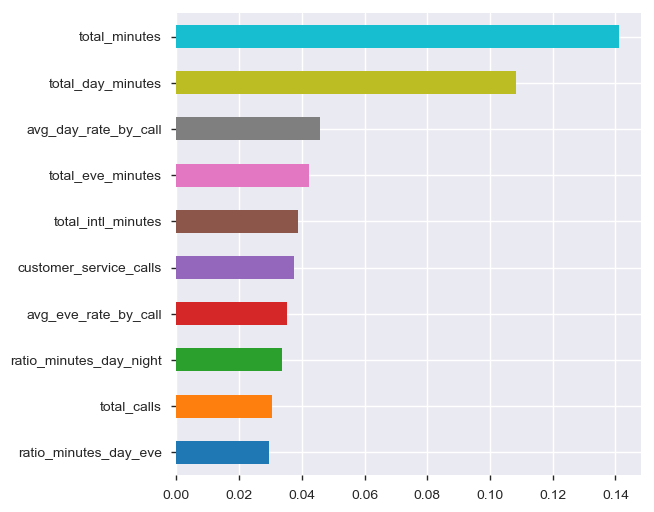

In [55]:
n_estimators = list(range(20,120,10))
max_depth = list(range(2, 12, 2)) + [None]


def rfscore(X,y,test_size,n_estimators,max_depth):

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) 
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    print("best max_depth:",max_depth_best)
    print("best n_estimators:",n_estimators_best)
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    best_rf_gs.fit(X_train,y_train)  # fitting the best model
    best_rf_score = best_rf_gs.score(X_test,y_test) 
    print ("best score is:",round(best_rf_score,3))
    preds = best_rf_gs.predict(X_test)
    print('Features and their importance:\n')
    feature_importances = pd.Series(best_rf_gs.feature_importances_, index=X.columns).sort_values().tail(10)
    print(feature_importances)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return rf_gs.best_params_ # printing the best parameters


rfscore(X,y,0.3,n_estimators,max_depth)

### Cross Validation

In [53]:
def cv_score(X,y,cv,n_estimators,max_depth):
    rf = RandomForestClassifier(n_estimators=n_estimators_best,
                                max_depth=max_depth_best)
    s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    return("{} Score is :{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

In [56]:
dict_best = {'max_depth': 10, 'n_estimators': 50}
n_estimators_best = dict_best['n_estimators']
max_depth_best = dict_best['max_depth']
cv_score(X,y,5,n_estimators_best,max_depth_best)

'Random Forest Score is :0.9 ± 0.012'

### Baseline

Baseline is high but score is higher.

In [57]:
df['churn'].value_counts()/df.shape[0]

0    0.857571
1    0.142429
Name: churn, dtype: float64

### Confusion Matrix

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = 0.3, random_state=42) 

best_rf_gs = RandomForestClassifier(n_estimators=n_estimators_best,
                                max_depth=max_depth_best)

best_rf_gs.fit(X_train,y_train)  # fitting the best model
best_rf_score = best_rf_gs.score(X_test,y_test) 
preds = best_rf_gs.predict(X_test)
pd.crosstab(pd.concat([X_test,y_test],axis=1)['churn'], preds, 
            rownames=['Actual Values'], colnames=['Predicted Values'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predicted Values,0,1
Actual Values,,
0,171,2
1,20,8


### To be continued